In [1]:
# import the needed packages
import pandas as pd
import stlearn as st
import scanpy as sc
import scanpy.external as sce
import squidpy as sq
import matplotlib.pyplot as plt
import os
import sys
import subprocess
import numpy as np
import anndata as ad
from anndata import AnnData
import matplotlib as mpl
import seaborn as sns

import monkeybread as mb

# make sure that we are in the right directory
print(os.getcwd())

# set the filenames we are looking at
filenames = ["S17_7722_E4", "S1614455_C21"]
pop_samples = ['Haitian', 'Haitian']

/mnt/scratch1/miniconda3/envs/stlearn/lib/python3.9/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)
/mnt/scratch1/miniconda3/envs/stlearn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/mnt/plummergrp/QuPath_0.4.4/BrCa


In [ ]:
for i in range(len(filenames)):

    df = pd.read_csv("./"+filenames[i]+".txt", sep='\t', lineterminator='\n')

    # create the cell matrix
    df_mat = df[df.columns[df.columns.str.contains("Cell: Mean")]]
    # leave only protein names
    df_mat.columns = df_mat.columns.str.replace(': Cell: Mean', '')
    # drop DAP1 because it is inconsequential to the downstream analysis
    # df_mat = df_mat.drop(columns=["DAPI"])
    # drop genes that have bad stitchings
    df_mat = df_mat.drop(columns=['CD11c', 'CD34', 'CyclinD1', 'G6PD', 'CD15'])
    # need to increase the index by 1 so that it doesn't start at 0
    df_mat.index = df_mat.index + 1
    # save it as a csv
    df_mat.to_csv("./"+filenames[i]+"_matrix.csv", index=True)

    # create the metadata file
    df_meta = df[['Centroid X µm','Centroid Y µm','Nucleus: Area µm^2']].copy()
    # calculate the cytoplasm as the cell minus the nucleus
    df_meta.loc[:, 'Cytoplasm: Area µm^2'] = df['Cell: Area µm^2'].sub(df['Nucleus: Area µm^2'])
    # need to increase the index by 1 so that it doesn't start at 0
    df_meta.index = df_meta.index + 1
    # save it as a csv
    df_meta.to_csv("./"+filenames[i]+"_metadata.csv", index=True)

/mnt/scratch1/miniconda3/envs/stlearn/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


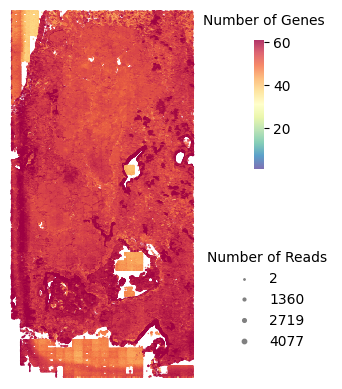

AnnData object with n_obs × n_vars = 1015567 × 61
    obs: 'imagecol', 'imagerow'
    uns: 'spatial'
    obsm: 'spatial'


/mnt/scratch1/miniconda3/envs/stlearn/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


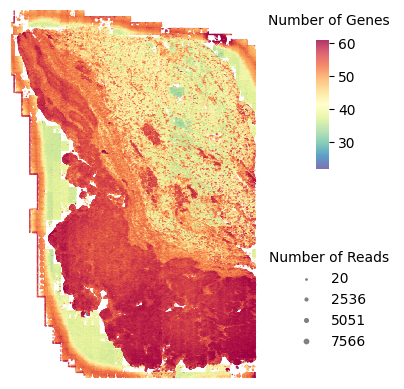

AnnData object with n_obs × n_vars = 1537975 × 61
    obs: 'imagecol', 'imagerow'
    uns: 'spatial'
    obsm: 'spatial'


In [4]:
# load the data into Anndata
adatas = []

for i in range(len(filenames)):
    count_matrix = pd.read_csv('./'+filenames[i]+'_matrix.csv', index_col=0)
    spatial = pd.read_csv('./'+filenames[i]+'_metadata.csv', index_col=0)
    spatial = spatial[['Centroid X µm', 'Centroid Y µm']]
    spatial = spatial.rename(columns={'Centroid X µm': 'imagecol', 'Centroid Y µm': 'imagerow'})

    adatas.append(st.create_stlearn(count=count_matrix,spatial=spatial,library_id="Sample_test", scale=1,background_color="white"))
    st.pl.QC_plot(adatas[i], spot_size=(1,10))
    print(adatas[i])

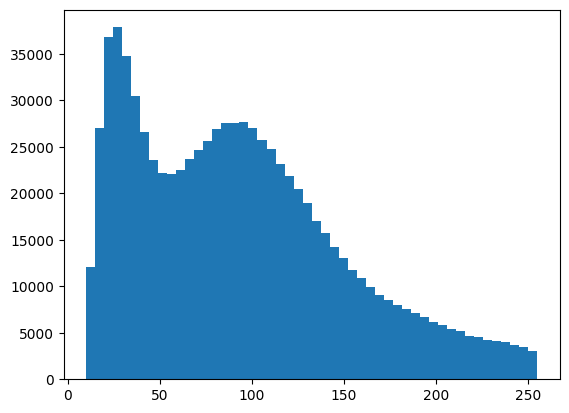

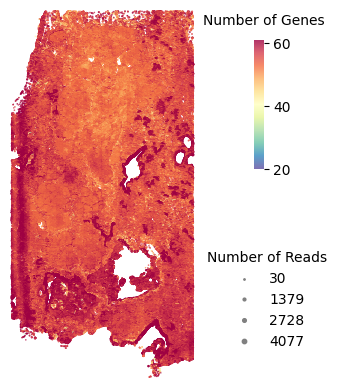

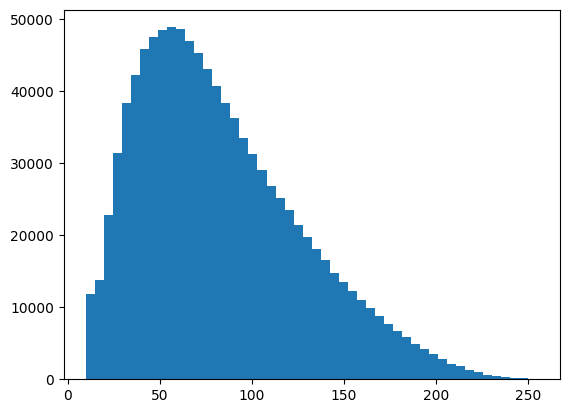

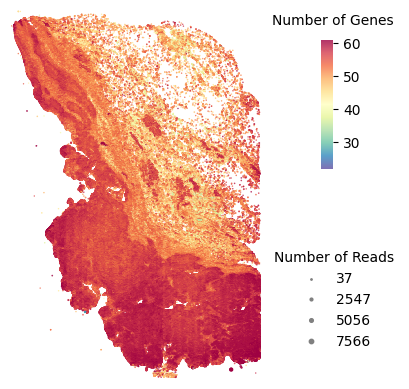

Index(['CD8', 'HLA-A', 'CD4', 'pNRF2', 'CD20', 'ER', 'Keratin 14', 'Vimentin',
       'PR', 'E-cadherin', 'CD31', 'PDL1', 'CD45RO', 'Keratin19', 'CD3e',
       'IDO1', 'SMA', 'GranzymeB', 'Keratin5', 'CollagenIV', 'Podoplanin',
       'CD14', 'FoxP3', 'ASCT2', 'CD45', 'tp63', 'CD44', 'HLA-DR', 'PD1',
       'ERG', 'b-catenin1', 'HER2', 'CD57', 'Keratin8', 'CD163', 'GATA3',
       'S100A4', 'CD68', 'HIF1A', 'Keratin18', 'FoxA1', 'LaminB1', 'CD227',
       'H2AX', 'PCNA', 'Keratin17', 'CPT1A', 'BAK', 'PARP', 'Keratin7',
       'Dnmt1', 'FAP', 'Glut1', 'p53', 'MMP9', 'Cytokeratin6', 'CD11b', 'Ki67',
       'Pan-Cytokeratin', 'CD66b'],
      dtype='object')
View of AnnData object with n_obs × n_vars = 835462 × 60
    obs: 'imagecol', 'imagerow'
    uns: 'spatial'
    obsm: 'spatial'
Index(['CD8', 'HLA-A', 'CD4', 'pNRF2', 'CD20', 'ER', 'Keratin 14', 'Vimentin',
       'PR', 'E-cadherin', 'CD31', 'PDL1', 'CD45RO', 'Keratin19', 'CD3e',
       'IDO1', 'SMA', 'GranzymeB', 'Keratin5', 'CollagenI

In [5]:
# remove stardist artifacts using DAPI expression level
n_bins = 50
for i in range(len(filenames)):
    adatas[i] = adatas[i][adatas[i][:, 'DAPI'].X > 10, :]
    # find out histogram of DAPI expression
    plt.hist(adatas[i].X[:,0], n_bins)
    plt.show()
    st.pl.QC_plot(adatas[i], spot_size=(1,10))

# remove DAPI from the anndatas
genes = pd.Index.tolist(adatas[i].var_names)
genes = genes[1::]
for i in range(len(filenames)):
    adatas[i] = adatas[i][:,genes]
    print(adatas[i].var_names)
    print(adatas[i])

# find all the gene names
genes = pd.Index.tolist(adatas[0].var_names)

# produce gene expression plots
for i in range(len(filenames)):
    for gene in genes:
        st.pl.gene_plot(adatas[i], gene_symbols=gene)
        plt.show()

In [ ]:
# clr normalization method courtesy of maximz
# https://github.com/scverse/scanpy/issues/1208
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [ ]:
# normalize the datasets individually
for i in range(len(filenames)):
    st.pp.filter_genes(adatas[i],min_cells=1)
    clr_normalize_each_cell(adatas[i])

# combine the datasets
adata = adatas[0]
for i in range(len(filenames)-1):
    adata = adata.concatenate(adatas[i+1])
print(adata.obs['batch'])

# save the anndata!
adata.write_h5ad('./session_file.h5ad')

# copy anndata for other batch correction techniques
# adata_bbknn = adata.copy()
# adata_scanorama = adata.copy()

new way of running harmonypy using a python script instead
first run the following commands in terminal:
export NUM_THREADS=1
export OPENBLAS_NUM_THREADS=1
export OMP_NUM_THREADS=1

now run the python script
python RunHarmony.py

2023-10-25 16:07:42.290596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 16:07:42.431229: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 16:07:43.021398: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-25 16:07:43.021467: W tensorflow/compiler/xla/stream_executor/platform/default/dso_lo

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
UMAP is done! Generated in adata.obsm['X_umap'] nad adata.uns['umap']


/mnt/scratch1/miniconda3/envs/stlearn/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/scratch1/miniconda3/envs/stlearn/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


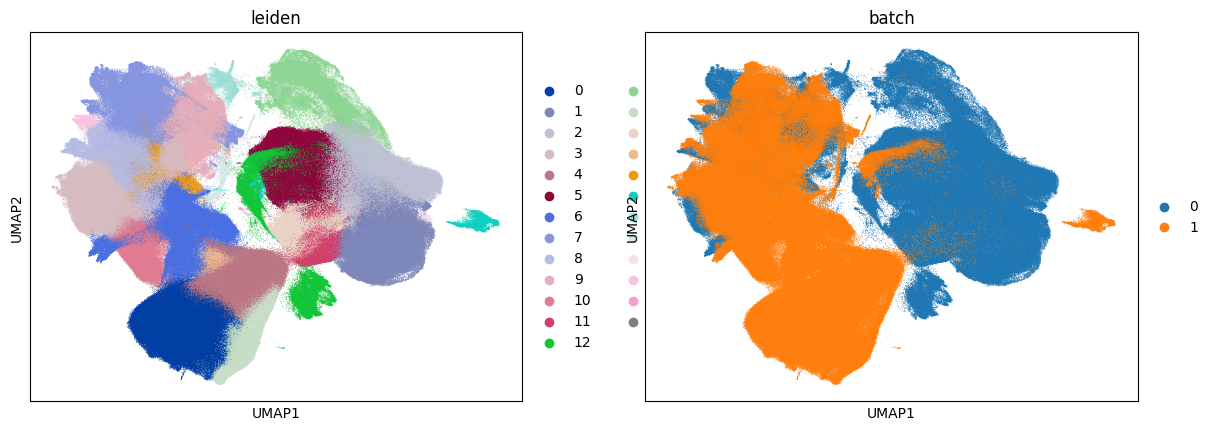

In [2]:
# load anndata
adata = ad.read_h5ad('./session_file_harmony.h5ad')
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

# calculate nneighbours
st.pp.neighbors(adata,n_neighbors=30,use_rep='X_pca')

# run umap
st.em.run_umap(adata)

# run leiden clustering
sc.tl.leiden(adata, resolution=0.5)

# umap
sc.pl.umap(adata, color=['leiden', 'batch'], size=1)
adata

# save it because it takes a long time
adata.write_h5ad('./session_file_harmony.h5ad')

Scale step is finished in adata.X


/mnt/scratch1/miniconda3/envs/stlearn/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


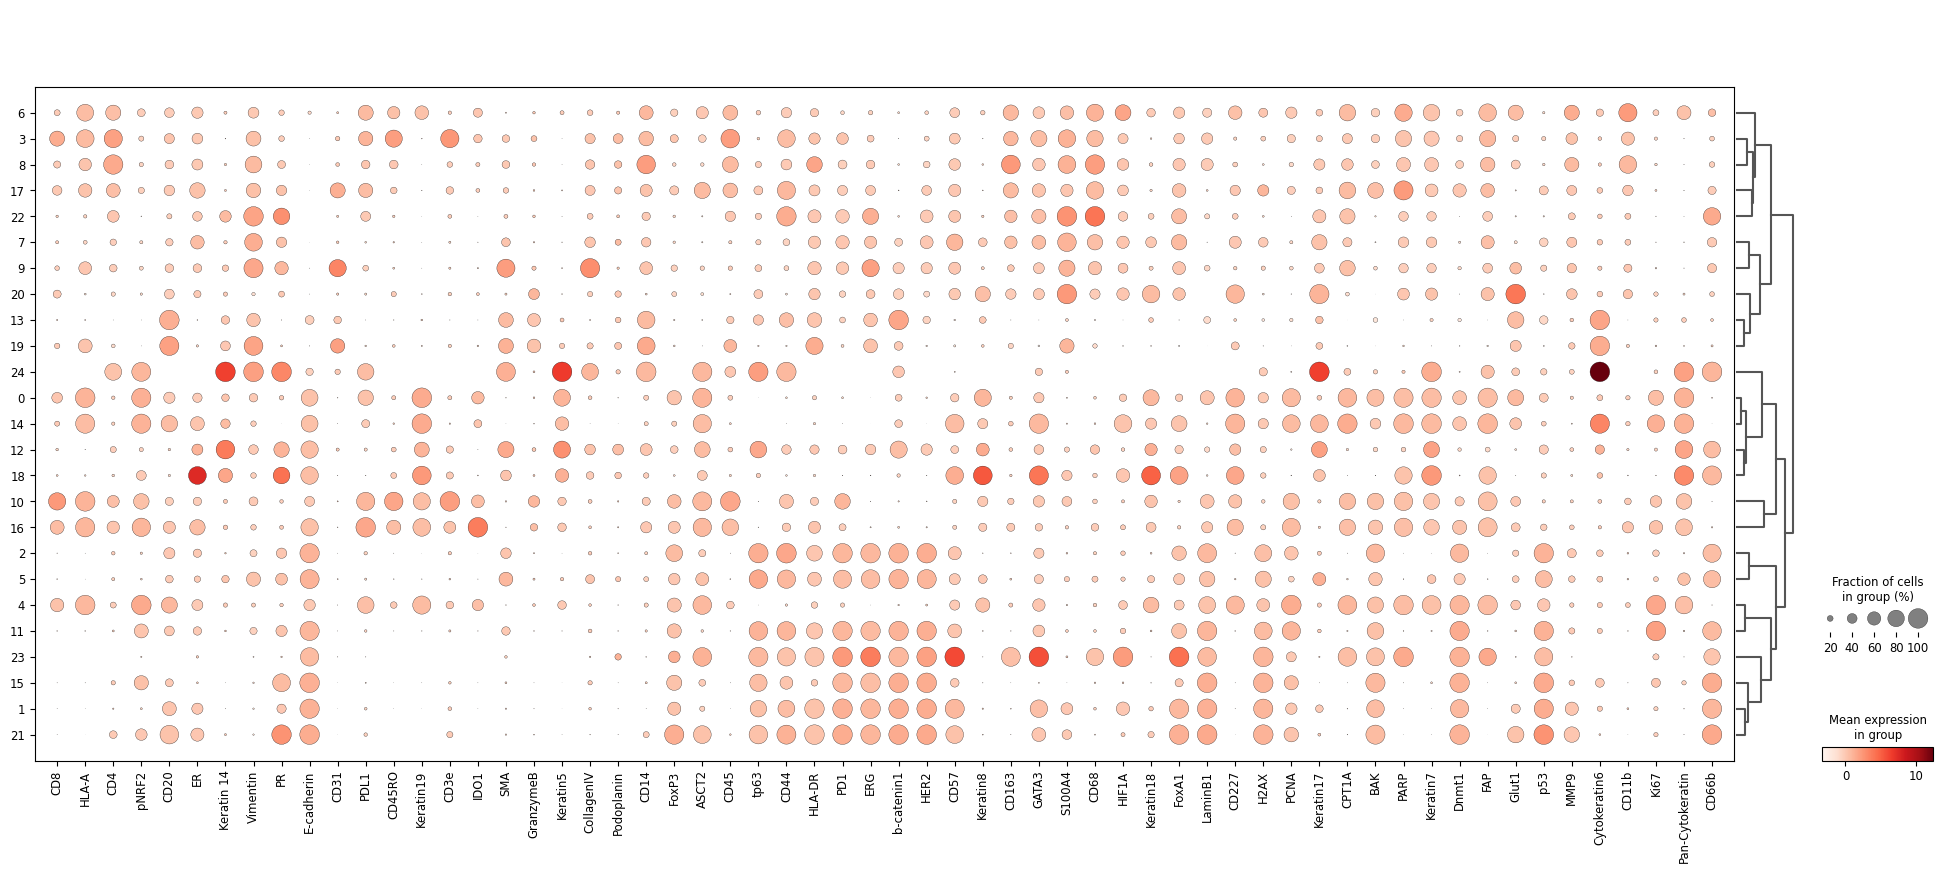

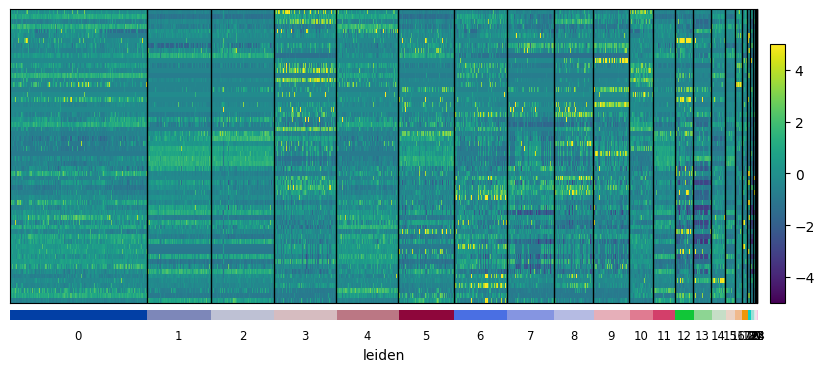

In [8]:
# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# scale for the dotplot
adata_scaled = adata.copy()
st.pp.scale(adata_scaled)

# create gene expression dotplot
sc.pl.dotplot(adata_scaled, genes, groupby='leiden', dendrogram=True)

# create gene expression heatmap
sc.pl.heatmap(adata_scaled, genes, groupby='leiden', swap_axes=True, vmin=-5, vmax=5)

/tmp/ipykernel_4001431/3384215711.py:9: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_samples[i].uns['spatial'] = adatas[i].uns['spatial']


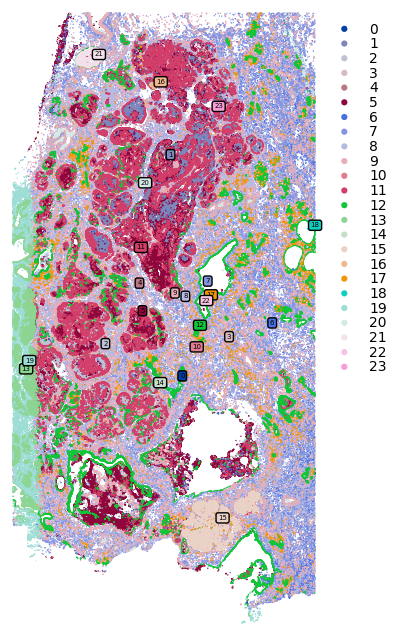

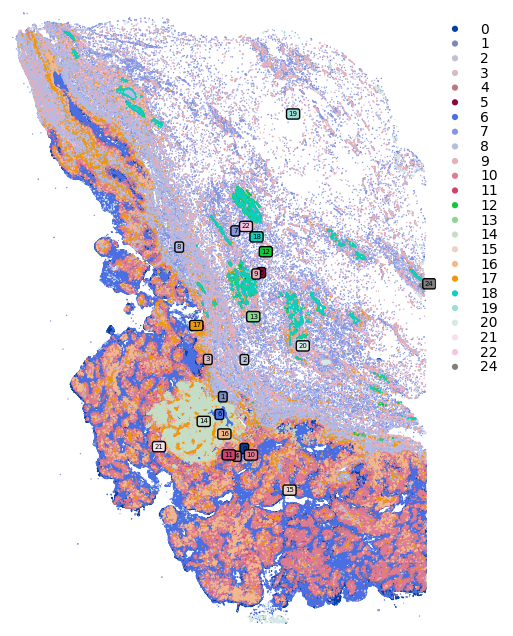

In [6]:
# map the clusters onto the tissues
# load anndata
# adata = ad.read_h5ad('../rapids-single-cell-examples-master/notebooks/session_file_harmony.h5ad')

adata_samples = []
for i in range(len(filenames)):
    adata_samples.append(adata[adata.obs['batch'] == str(i)])
    # adata_samples.append(adata[adata.obs['batch'] == "sample"+str(i)])  
    adata_samples[i].uns['spatial'] = adatas[i].uns['spatial']
    st.pl.cluster_plot(adata_samples[i],use_label="leiden", show_cluster_labels=True, size=1, figsize=(8, 8))
    plt.show()


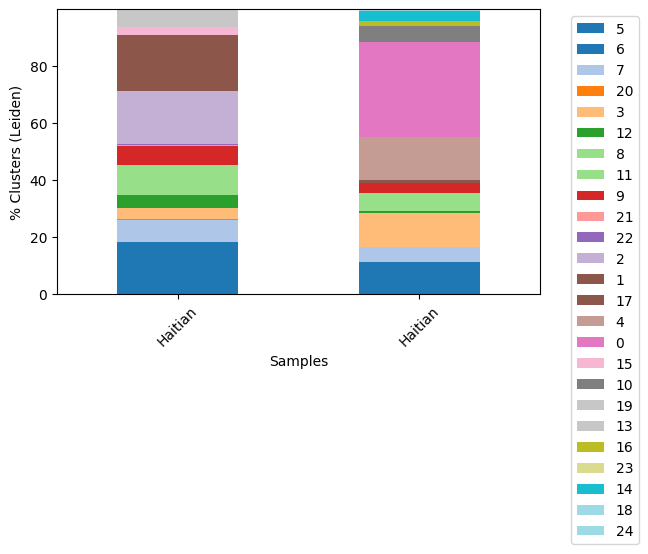

In [7]:
# proportion of clusters in each sample
plt_data_samples = []
for i in range(len(filenames)):
    plt_data_sample={}
    for v in adata_samples[i].obs['leiden'].unique():
        plt_data_sample[v]=adata_samples[i][adata_samples[i].obs['leiden']==v].shape[0]/adata_samples[i].shape[0]*100
    plt_data_samples.append(plt_data_sample)

df = pd.DataFrame.from_dict(plt_data_samples[0],orient='index')  
for i in range(len(filenames)-1):
    df = pd.concat([df, pd.DataFrame.from_dict(plt_data_samples[i+1],orient='index')], axis=1)  
df.columns = pop_samples

df.T.plot(kind='bar', stacked=True, colormap='tab20')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Samples")
plt.xticks(rotation=45)
plt.ylabel("% Clusters (Leiden)")
plt.show()

In [10]:
# neighbourhood analysis
# set up
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor="white")

for i in range(len(filenames)):
    sq.gr.spatial_neighbors(adata_samples[i])

    # neighbourhood enrichment
    sq.gr.nhood_enrichment(adata_samples[i], cluster_key="leiden")
    sq.pl.nhood_enrichment(adata_samples[i], cluster_key="leiden", method="average", figsize=(5, 5))
    plt.show()

    # interaction matrix
    sq.gr.interaction_matrix(adata_samples[i], cluster_key="leiden")
    sq.pl.interaction_matrix(adata_samples[i], cluster_key="leiden", method="average", figsize=(5, 5))
    plt.show()


Creating graph using `grid` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:07)
Calculating neighborhood enrichment using `1` core(s)


100%|██████████| 1000/1000 [01:00<00:00, 16.40/s]


Adding `adata.uns['leiden_nhood_enrichment']`
Finish (0:01:01)


ValueError: The condensed distance matrix must contain only finite values.

# niche analysis
other_cell_types = ['8','3']

niche_subtypes_sample1 = []
for cell, ct in zip(adata_sample1.obs.index, adata_sample1.obs['leiden']):
    if ct in other_cell_types:
        niche_subtypes_sample1.append('malignant/other')
    else:
        niche_subtypes_sample1.append(ct)
adata_sample1.obs['niche_subtypes'] = niche_subtypes_sample1
adata_sample1.obs['niche_subtypes'] = adata_sample1.obs['niche_subtypes'].astype('category')

print("Cell subtypes considered in niche analysis:")
print(set(adata_sample1.obs['niche_subtypes']))

niche_subtypes_sample2 = []
for cell, ct in zip(adata_sample2.obs.index, adata_sample2.obs['leiden']):
    if ct in other_cell_types:
        niche_subtypes_sample2.append('malignant/other')
    else:
        niche_subtypes_sample2.append(ct)
adata_sample2.obs['niche_subtypes'] = niche_subtypes_sample2
adata_sample2.obs['niche_subtypes'] = adata_sample2.obs['niche_subtypes'].astype('category')

print("Cell subtypes considered in niche analysis:")
print(set(adata_sample2.obs['niche_subtypes']))

adata_sample1.obsm['X_spatial'] = adata_sample1.obsm['spatial']
adata_sample2.obsm['X_spatial'] = adata_sample2.obsm['spatial']

immune_mask_sample1 = ~adata_sample1.obs['niche_subtypes'].isin([
    'malignant/other'
])
immune_mask_sample2 = ~adata_sample2.obs['niche_subtypes'].isin([
    'malignant/other'
])

# Compute niches
adata_neighbors_sample1 = mb.calc.cellular_niches(
    adata_sample1,
    cell_type_key='niche_subtypes',
    radius=75,
    normalize_counts=True,
    standard_scale=True,
    clip_min=-5,
    clip_max=5,
    n_neighbors=100,
    resolution=0.25,
    min_niche_size=300,
    key_added='niche',
    non_niche_value='malignant/other',
    mask=immune_mask_sample1
)

adata_neighbors_sample2 = mb.calc.cellular_niches(
    adata_sample2,
    cell_type_key='niche_subtypes',
    radius=75,
    normalize_counts=True,
    standard_scale=True,
    clip_min=-5,
    clip_max=5,
    n_neighbors=100,
    resolution=0.25,
    min_niche_size=300,
    key_added='niche',
    non_niche_value='malignant/other',
    mask=immune_mask_sample2
)

# visualize the distribution of neighbourhood profile values for a subset of
# the cell types
sns.histplot(adata_neighbors_sample1.obs_vector('1'))
plt.xlabel('Normalized neighbor counts')
plt.ylabel('Number of cells')
plt.title('1')
plt.show()

sns.histplot(adata_neighbors_sample1.obs_vector('0'))
plt.xlabel('Normalized neighbor counts')
plt.ylabel('Number of cells')
plt.title('0')
plt.show()

sns.histplot(adata_neighbors_sample2.obs_vector('1'))
plt.xlabel('Normalized neighbor counts')
plt.ylabel('Number of cells')
plt.title('1')
plt.show()

sns.histplot(adata_neighbors_sample2.obs_vector('0'))
plt.xlabel('Normalized neighbor counts')
plt.ylabel('Number of cells')
plt.title('0')
plt.show()

# Subset cells
adata_neighbors_sub_sample1 = sc.pp.subsample(
    adata_neighbors_sample1, fraction=1/2, copy=True
)

adata_neighbors_sub_sample2 = sc.pp.subsample(
    adata_neighbors_sample2, fraction=1/2, copy=True
)

# Generate UMAP plots
sc.tl.umap(adata_neighbors_sub_sample1,  n_components=2)
sc.pl.umap(
    adata_neighbors_sub_sample1, 
    color='niche_subtypes', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)
sc.pl.umap(
    adata_neighbors_sub_sample1, 
    color='niche', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)

sc.tl.umap(adata_neighbors_sub_sample2,  n_components=2)
sc.pl.umap(
    adata_neighbors_sub_sample2, 
    color='niche_subtypes', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)
sc.pl.umap(
    adata_neighbors_sub_sample2, 
    color='niche', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)

# Map each niche to a color so that plots are consistent
niche_to_color_sample1 = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set(adata_neighbors_sample1.obs['niche'])))
}

fig, ax = plt.subplots(1,1,figsize=(15,15))
sc.pl.embedding(
    adata_sample1,
    "spatial",
    color = 'niche',
    palette=niche_to_color_sample1,
    size=1,
    ax=ax,
    show=False
)
plt.show()

niche_to_color_sample2 = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set(adata_neighbors_sample2.obs['niche'])))
}

fig, ax = plt.subplots(1,1,figsize=(15,15))
sc.pl.embedding(
    adata_sample2,
    "spatial",
    color = 'niche',
    palette=niche_to_color_sample2,
    size=1,
    ax=ax,
    show=False,
)
plt.show()

# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# scale the data
adata_sample1_scaled = adata_sample1.copy()
st.pp.scale(adata_sample1_scaled, zero_center=True)

adata_sample2_scaled = adata_sample2.copy()
st.pp.scale(adata_sample2_scaled, zero_center=True)

# create gene expression heatmap
sc.pl.heatmap(adata_sample1_scaled, genes, groupby='niche', show_gene_labels=True, swap_axes=True, vmin=-5, vmax=8)
sc.pl.heatmap(adata_sample2_scaled, genes, groupby='niche', show_gene_labels=True, swap_axes=True, vmin=-5, vmax=8)

# proportion of niches in each sample
plt_data_sample1={}
for v in adata_sample1.obs['niche'].unique():
    plt_data_sample1[v]=adata_sample1[adata_sample1.obs['niche']==v].shape[0]/adata_sample1.shape[0]*100

plt_data_sample2={}
for v in adata_sample2.obs['niche'].unique():
    plt_data_sample2[v]=adata_sample2[adata_sample2.obs['niche']==v].shape[0]/adata_sample2.shape[0]*100

df1 = pd.DataFrame.from_dict(plt_data_sample1,orient='index',columns=['Haitian'])    
df2 = pd.DataFrame.from_dict(plt_data_sample2,orient='index',columns=['African American'])    

df = pd.concat([df1,df2],axis=1)
df.T.plot(kind='bar', stacked=True, colormap='tab20')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Samples")
plt.xticks(rotation=45)
plt.ylabel("% Niches")
plt.show()

In [ ]:
# niche analysis of the combined data 
niche_subtypes = []
other_cell_types = ['8','3']

for cell, ct in zip(adata.obs.index, adata.obs['leiden']):
    if ct in other_cell_types:
        niche_subtypes.append('malignant/other')
    else:
        niche_subtypes.append(ct)
adata.obs['niche_subtypes'] = niche_subtypes
adata.obs['niche_subtypes'] = adata.obs['niche_subtypes'].astype('category')

print("Cell subtypes considered in niche analysis:")
print(set(adata.obs['niche_subtypes']))

adata.obsm['X_spatial'] = adata.obsm['spatial']
immune_mask = ~adata.obs['niche_subtypes'].isin([
    'malignant/other'
])

# Compute niches
adata_neighbors = mb.calc.cellular_niches(
    adata,
    cell_type_key='niche_subtypes',
    radius=75,
    normalize_counts=True,
    standard_scale=True,
    clip_min=-5,
    clip_max=5,
    n_neighbors=100,
    resolution=0.25,
    min_niche_size=300,
    key_added='niche',
    non_niche_value='malignant/other',
    mask=immune_mask
)

# Subset cells
adata_neighbors_sub = sc.pp.subsample(
    adata_neighbors, fraction=1/2, copy=True
)

# Generate UMAP plots
sc.tl.umap(adata_neighbors_sub,  n_components=2)
sc.pl.umap(
    adata_neighbors_sub, 
    color='niche_subtypes', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)
sc.pl.umap(
    adata_neighbors_sub, 
    color='niche', 
    palette=sc.pl.palettes.vega_20_scanpy,
    projection='2d'
)

print(adata)

In [ ]:
# Map each niche to a color so that plots are consistent
niche_to_color = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set(adata_neighbors.obs['niche'])))
}

adata_niches = []
for i in range(len(filenames)):
    adata_niches.append(adata[adata.obs['batch'] == str(i)])

    fig, ax = plt.subplots(1,1,figsize=(10,10))
    sc.pl.embedding(
        adata_niches[i],
        "spatial",
        color = 'niche',
        palette=niche_to_color,
        size=1,
        ax=ax,
        show=False,
    )
    plt.show()

In [ ]:
# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# scale the data
adata_niches_scaled = []
for i in range(len(filenames)):
    adata_niches_scaled.append(adata_niches[i].copy())
    st.pp.scale(adata_niches_scaled[i], zero_center=True)

    # create gene expression heatmap
    sc.pl.heatmap(adata_niches_scaled[i], genes, groupby='niche', show_gene_labels=True, swap_axes=True, vmin=-5, vmax=5)

In [ ]:
# proportion of niches in each sample
plt_data_niches = []
for i in range(len(filenames)):
    plt_data_niche = {}
    for v in adata_niches[i].obs['niche'].unique():
        plt_data_niche[v]=adata_niches[i][adata_niches[i].obs['niche']==v].shape[0]/adata_niches[i].shape[0]*100
    plt_data_niches.append(plt_data_niche)


df = pd.DataFrame.from_dict(plt_data_niches[0],orient='index')  
for i in range(len(filenames)-1):
    df = pd.concat([df, pd.DataFrame.from_dict(plt_data_niches[i+1],orient='index')], axis=1)  
df.columns = pop_samples

df.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(8,8))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Samples")
plt.xticks(rotation=45)
plt.ylabel("% Niches")
plt.show()

In [ ]:
# load in the astir generated cell types and plot onto the tissues
celltypes = []
for i in range(len(filenames)):
    celltypes.append(pd.read_csv('./'+filenames[i]+'_cell-types.csv', index_col=0)['cell_type'])

for i in range(len(filenames)):
    adatas[i].obs['celltypes'] = celltypes[i].to_numpy()
    adatas[i].obs['celltypes'] = adatas[i].obs['celltypes'].astype('category')

set_celltypes = {'Normal Epithelial cells',
                 'Tumor cells', 
                 'Proliferating Tumor cells',
                 'Myoepithelial cells',
                 'Granulocytes',
                 'Telocytes',
                 'Endothelial cells',
                 'M2 Macrophages',
                 'M1 Macrophages',
                 'Fibroblasts',
                 'B cells',
                 'Cytotoxic T cells',
                 'Tregs',
                 'Helper T cells',
                 'Unknown',
                 'Other'}

# Map each niche to a color so that plots are consistent
type_to_color = {
    val: mb.plot.monkey_palette[i]
    for i, val in enumerate(sorted(set_celltypes))
}

for i in range(len(filenames)):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    sc.pl.embedding(
        adatas[i],
        "spatial",
        color = 'celltypes',
        palette=type_to_color,
        size=2,
        ax=ax,
        show=False
    )
    plt.show()

In [ ]:
# generate heatmap and dotplot grouped by the cell types
# load anndata
adata = ad.read_h5ad('./session_file_harmony.h5ad')
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

temp_adata = adatas[0]
for i in range(len(filenames)-1):
    temp_adata = temp_adata.concatenate(adatas[i+1])
adata.obs['celltypes'] = temp_adata.obs['celltypes']

# find all the gene names
genes = pd.Index.tolist(adata.var_names)

# scale for the dotplot
adata_scaled = adata.copy()
st.pp.scale(adata_scaled)

# create gene expression dotplot
sc.pl.dotplot(adata_scaled, genes, groupby='celltypes', dendrogram=True)

# create gene expression heatmap
sc.pl.heatmap(adata_scaled, genes, groupby='celltypes', swap_axes=True, vmin=-5, vmax=5)


In [ ]:
# proportion of cell types in each sample
plt_data_types = []
for i in range(len(filenames)):
    plt_data_type = {}
    for v in adatas[i].obs['celltypes'].unique():
        plt_data_type[v]=adatas[i][adatas[i].obs['celltypes']==v].shape[0]/adatas[i].shape[0]*100
    plt_data_types.append(plt_data_type)

df = pd.DataFrame.from_dict(plt_data_types[0],orient='index')  
for i in range(len(filenames)-1):
    df = pd.concat([df, pd.DataFrame.from_dict(plt_data_types[i+1],orient='index')], axis=1)  
df.columns = pop_samples

df.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(8,8))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.xlabel("Samples")
plt.xticks(rotation=45)
plt.ylabel("% Cell Types")
plt.show()

In [ ]:
# plot individual cell type probabilities
cellprobs = []
for i in range(len(filenames)):
    count_matrix = pd.read_csv('./'+filenames[i]+'_cell-probs.csv', index_col=0)
    spatial = pd.read_csv('./'+filenames[i]+'_metadata.csv', index_col=0)
    spatial = spatial[['Centroid X µm', 'Centroid Y µm']]
    spatial = spatial.rename(columns={'Centroid X µm': 'imagecol', 'Centroid Y µm': 'imagerow'})
    cellprobs.append(st.create_stlearn(count=count_matrix,spatial=spatial,library_id="Sample_test", scale=1,background_color="white"))

# find all the cell types
types = pd.Index.tolist(cellprobs[0].var_names)

# produce gene expression plots
for i in range(len(filenames)):
    for type in types:
        st.pl.gene_plot(cellprobs[i], gene_symbols=type, figsize=(8,8), cmap='cividis', vmin=0, vmax=1, size=1)
        plt.show()

In [ ]:
import pickle
# run spatial-LDA
immune_cells = ['Granulocytes', ' M2 Macrophages', 'M1 Macrophages', 'B cells',
    'Cytotoxic T cells', 'Tregs', 'Helper T cells', 'Telocytes',
    'Fibroblasts']
non_immune_cells = ['Normal Epithelial cells', 'Tumor cells', 'Proliferating Tumor cells',
    'Myoepithelial cells', 'Endothelial cells']
tumors = ['Tumor cells', 'Proliferating Tumor cells']

patient_dfs = {}
for i in range(len(filenames)):
    export = pd.read_csv("./"+filenames[i]+".txt", sep='\t', lineterminator='\n')
    df = pd.DataFrame(adata_samples[i].X, columns=adata_samples[i].var_names)
    df['cluster_id'] = adata_samples[i].obs['leiden'].to_numpy()
    df['x'] = adata_samples[i].obs['imagecol'].to_numpy()
    df['y'] = adata_samples[i].obs['imagerow'].to_numpy()
    df['area'] = export['Cell: Area µm^2']
    celltype_split = adatas[i].obs['celltypes'].to_numpy()
    isimmune = []
    immune_cluster = []
    cluster_id = []
    combined_cluster_id = []
    is_tumor = []
    for j in celltype_split:
        combined_cluster_id.append(j)
        if j in immune_cells:
            isimmune.append(True)
            immune_cluster.append(j)
            cluster_id.append(np.nan)
            is_tumor.append(False)
        else:
            isimmune.append(False)
            immune_cluster.append(np.nan)
            cluster_id.append(j)
            if j in tumors:
                is_tumor.append(True)
            else:
                is_tumor.append(False)
    df['isimmune'] = isimmune
    df['immune_cluster'] = immune_cluster
    df['cluster_id'] = cluster_id
    df['combined_cluster_id'] = combined_cluster_id
    df['is_tumor'] = is_tumor
    patient_dfs[i+1] = df

with open('../Spatial-LDA/patient_dfs1.pkl', 'wb') as file:
    pickle.dump(patient_dfs, file)

In [ ]:
# save anndata
adata.write_h5ad('./session_file_adata.h5ad')
for i in range(len(filenames)):
    adata_samples[i].write_h5ad('./session_file_adata_sample'+str(i+1)+'.h5ad')
    adata_niches[i].write_h5ad('./session_file_adata_niche'+str(i+1)+'.h5ad')
    adatas[i].write_h5ad('./session_file_adata'+str(i+1)+'.h5ad')

In [ ]:
# load anndata
adata_samples = []
adata_niches = []
adatas = []
adata = ad.read_h5ad('./session_file_adata.h5ad')
for i in range(len(filenames)):
    adata_samples.append(ad.read_h5ad('./session_file_adata_sample'+str(i+1)+'.h5ad'))
    adata_niches.append(ad.read_h5ad('./session_file_adata_niche'+str(i+1)+'.h5ad'))
    adatas.append(ad.read_h5ad('./session_file_adata'+str(i+1)+'.h5ad'))